In [1]:
import pandas as pd
from io import StringIO
import requests

import logging
import boto3
from botocore.exceptions import ClientError
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
def file_preparation(response, file_name, bucket):
    if response.status_code == 200: 
        data = response.json()
        df = pd.json_normalize(data)
        df.to_csv(file_name, index=False)
        upload_file('./' + file_name, bucket, file_name)
        print('Ok') 
    else:
        print("Error: Failed to retrieve data from API")

In [2]:
def upload_file(file_name, bucket, object_name):
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [4]:
def read_data(file, bucket):
    s3 = boto3.resource('s3')
    s3_object = s3.Bucket(bucket).Object(file).get()
    data = s3_object['Body'].read().decode()
    pd_data = pd.read_csv(StringIO(data))
    return pd_data

In [14]:
def plot_data(df1, df2, graph_file_name, currency1, currency2):
    plt.plot(df1['exchangedate'], df1['rate'], label=currency1)
    plt.plot(df2['exchangedate'], df2['rate'], label=currency2)
    
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=70))
    plt.xlabel('2021 Year')
    plt.ylabel('Rate')
    plt.title('Currency rate over the years')
    plt.legend()

    plt.savefig(graph_file_name)
    upload_file('./'+graph_file_name, 'bucketawslab2', graph_file_name)

    plt.show()

In [6]:
urlEur = 'https://bank.gov.ua/NBU_Exchange/exchange_site?start=20210101&end=20211231&valcode=eur&sort=exchangedate&order=asc&json'
urlUsd = 'https://bank.gov.ua/NBU_Exchange/exchange_site?start=20210101&end=20211231&valcode=usd&sort=exchangedate&order=asc&json'

responseEur = requests.get(urlEur)
responseUsd = requests.get(urlUsd)

file_preparation(responseEur, 'outputEur.csv', 'bucketawslab2')
file_preparation(responseUsd, 'outputUsd.csv', 'bucketawslab2')

Ok
Ok


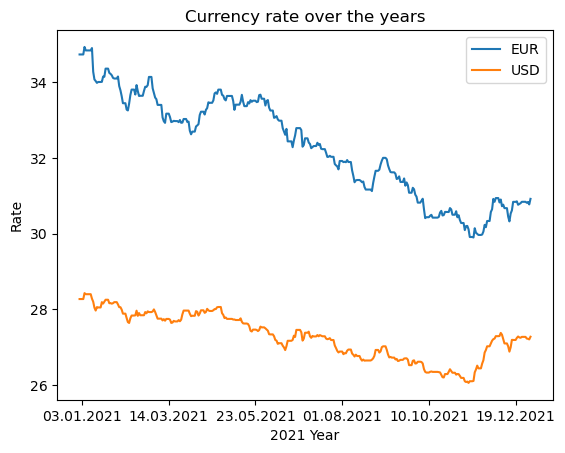

In [15]:
df_eur_data = read_data('outputEur.csv', 'bucketawslab2')
df_usd_data = read_data('outputUsd.csv', 'bucketawslab2')

plot_data(df_eur_data, df_usd_data, 'graph.png', 'EUR', 'USD')
